# Exploring the Design Space
Here, we will demonstrate how to use TimeloopFE to conduct design space explorations
with Timeloop & Accelergy. We will use TimeloopFE to launch Timeloop+Accelergy jobs,
then gather the results from each.

In this design space exploration, we will use a simple architecture with a DRAM, a
global buffer, and an array of PEs which each have a register and a compute unit. We
will vary the number of PEs and the global buffer size.

We start by defining a `run_test` function that takes in a scale factor for the
global buffer size and a scale factor for the number of PEs. The function will
run the Timeloop mapper and return the global buffer size, number of PEs, and
energy in pJ/MAC.


In [1]:
import timeloopfe.v4 as tl
import os
TOP_PATH = f"{os.curdir}/top.yaml.jinja"

def run_test(global_buffer_size_scale: float, pe_scale: float, brief_print: bool=False):
    if brief_print:
        print('.', end='')
    # Set up the specification
    spec = tl.Specification.from_yaml_files(TOP_PATH)
    buf = spec.architecture.find("buffer")
    buf.attributes["depth"] = round(buf.attributes["depth"] * global_buffer_size_scale)
    pe = spec.architecture.find("PE")
    pe.spatial.meshX = round(pe.spatial.meshX * pe_scale)
    spec.mapper.search_size = 2000

    # Give each run a unique ID and run the mapper
    proc_id = f"glb_scale={global_buffer_size_scale},pe_scale={pe_scale}"
    if brief_print:
        print('.', end='')
    else:
        print(f"Starting {proc_id}")
    out_dir = f"{os.curdir}/outputs/{proc_id}"
    tl.call_mapper(spec, output_dir=out_dir, log_to=f"{out_dir}/output.log")

    # Grab the energy from the stats file
    stats = open(f"{out_dir}/timeloop-mapper.stats.txt").read()
    stats = [l.strip() for l in stats.split("\n") if l.strip()]
    energy = float(stats[-1].split("=")[-1])
    return (
        spec.architecture.find("buffer").attributes["depth"],
        spec.architecture.find("PE").spatial.meshX,
        energy,
    )


Rather than run each test sequentially in a `for` loop, we can use the joblib library
to multiprocess our calls and speed up design space exploration.


In [2]:
args = []
results = []
for global_buffer_size_scale in [0.5, 1, 2]:
    for n_pes in [0.5, 1, 2]:
        arg = (global_buffer_size_scale, n_pes)
        args.append(arg)

# Slow non-multi-processed implementation
# for arg in args:
#   results.append(run_test(*arg))

# Fast multiprocessed implementation
import joblib

results = joblib.Parallel(n_jobs=16)(
    joblib.delayed(run_test)(*arg) for arg in args
)

Starting glb_scale=0.5,pe_scale=0.5
Starting glb_scale=1,pe_scale=0.5
Starting glb_scale=0.5,pe_scale=2
Starting glb_scale=0.5,pe_scale=1
Starting glb_scale=1,pe_scale=1
Starting glb_scale=2,pe_scale=1
Starting glb_scale=1,pe_scale=2
Starting glb_scale=2,pe_scale=2
Starting glb_scale=2,pe_scale=0.5


In [3]:
for global_buffer_depth, n_pes, energy in results:
    print(
        f"Global buffer depth: {global_buffer_depth}, # PEs: {n_pes}, pJ/MAC: {energy}"
    )


Global buffer depth: 256, # PEs: 4, pJ/MAC: 7421.11
Global buffer depth: 256, # PEs: 8, pJ/MAC: 7361.87
Global buffer depth: 256, # PEs: 16, pJ/MAC: 7329.48
Global buffer depth: 512, # PEs: 4, pJ/MAC: 6560.17
Global buffer depth: 512, # PEs: 8, pJ/MAC: 6484.72
Global buffer depth: 512, # PEs: 16, pJ/MAC: 6446.99
Global buffer depth: 1024, # PEs: 4, pJ/MAC: 5999.92
Global buffer depth: 1024, # PEs: 8, pJ/MAC: 5879.88
Global buffer depth: 1024, # PEs: 16, pJ/MAC: 5819.85


Let's run a bigger test. We'll try out 20 different buffer sizes and plot the
Energy/MAC for each buffer size. Using this test, we can decide on the
lowest-energy buffer size for this system and workload. NOTE that the curve may
not be smooth; this is due to suboptimal mappings, and we could smooth the curve
better by running the mapper for much longer.

................................................................................

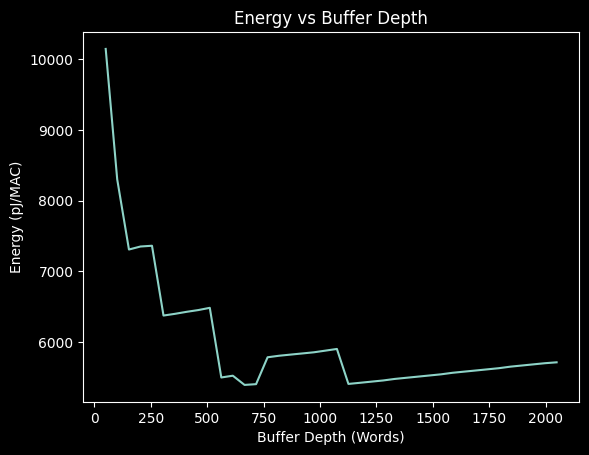

In [4]:
import shutil
import matplotlib.pyplot as plt

args = []
for step in range(1, 41):
    global_buffer_size_scale = step / 10
    args.append((global_buffer_size_scale, 1, True))

results = joblib.Parallel(n_jobs=20)(
    joblib.delayed(run_test)(*arg) for arg in args
)

buffer_depths = [r[0] for r in results]
energies = [r[2] for r in results]

plt.plot(buffer_depths, energies)
plt.xlabel('Buffer Depth (Words)')
plt.ylabel('Energy (pJ/MAC)')
plt.title('Energy vs Buffer Depth')
plt.show()

shutil.rmtree(f"{os.curdir}/outputs")